In [1]:
import torch
from torch import nn,optim
import torch.nn.functional as F
import torch.utils.data as tud
import torch.nn.parameter as Parameter

from collections import Counter
import numpy as np
import random
import math
import pandas as pd
import scipy
import sklearn
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
random.seed(53113)
np.random.seed(53113)
torch.manual_seed(53113)

In [3]:
K=100
C=3
NUM_EPOCHS=2
MAX_VOCAB_SIZE=30000
BATCH_SIZE=128
LEARNING_RATE=0.2
EMBEDDING_SIZE=100
LOG_FILE=r'F:\study\ml\DoctorChu-pytorch\2\word-embedding.log'

In [4]:
def word_tokenize(text):
    return text.split()

In [5]:
with open(r'F:\study\ml\DoctorChu-pytorch\2\text8\text8.train.txt') as fin:
    text=fin.read()

In [6]:
text=[w for w in word_tokenize(text.lower())]
text[:5]

['anarchism', 'originated', 'as', 'a', 'term']

In [7]:
Counter(text[:5])

Counter({'a': 1, 'anarchism': 1, 'as': 1, 'originated': 1, 'term': 1})

In [8]:
vocab=dict(Counter(text).most_common(MAX_VOCAB_SIZE-1))

In [9]:
vocab['aaa']

50

In [10]:
len(text)

15313011

In [11]:
np.sum(list(vocab.values()))

14695900

In [12]:
np.max(list(vocab.values()))

958035

In [13]:
vocab['<unk>']=len(text)-np.sum(list(vocab.values()))
idx_to_word=[word for word in vocab.keys()]
word_to_idx={word:i for i ,word in enumerate(idx_to_word)}

In [14]:
idx_to_word[:5]

['the', 'of', 'and', 'one', 'in']

In [15]:
word_to_idx['aaa']

17156

In [16]:
word_counts=np.array([count for count in vocab.values()],dtype=np.float32)
word_freqs=word_counts / np.sum(word_counts)
word_freqs=word_freqs **(3./4.)
word_freqs=word_freqs / np.sum(word_freqs)
VOCAB_SIZE=len(idx_to_word)
VOCAB_SIZE

30000

In [18]:
class WordEmbeddingDataset(tud.Dataset):
    def __init__(self,text,word_to_idx,idx_to_word,word_freqs,word_counts):
        super().__init__()
        self.text_encoded=[word_to_idx.get(t,VOCAB_SIZE-1) for t in text]
        self.text_encoded=torch.Tensor(self.text_encoded).long()
        self.word_to_idx=word_to_idx
        self.idx_to_word=idx_to_word
        self.word_freqs=torch.Tensor(word_freqs)
        self.word_counts=torch.Tensor(word_counts)
    
    def __len__(self):
        return len(self.text_encoded)
    
    def __getitem__(self,idx):
        center_word=self.text_encoded[idx]
        pos_indices=list(range(idx-C,idx)) + list(range(idx+1,idx+C+1))
        pos_indices=[i % len(self.text_encoded) for i in pos_indices]
        pos_words=self.text_encoded[pos_indices]
        neg_words=torch.multinomial(self.word_freqs,K*pos_words.shape[0],True)
        
        return center_word,pos_words,neg_words
        

In [19]:
dataset=WordEmbeddingDataset(text,word_to_idx,idx_to_word,word_freqs,word_counts)
dataloader=tud.DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True)

- 每次迭代,返回的数据形状
- 128是batch,即返回128个中心词的索引
- 128 * 6 返回,128-3 ~ 128+3 ,6个周围词的索引(相关的词)
- 128 * 600,返回6个周围词 ,每个周围词 100个负例采样的词(无关的词)

In [20]:
for i in next(iter(dataloader)):
    print(i.shape)

torch.Size([128])
torch.Size([128, 6])
torch.Size([128, 600])


- 使用nn.Embedding() 生成一个30000*100的字典,并用均匀分布初始化
- 然后根据索引,取出对应索引行的数据,如:in_embed(input_labels)

In [21]:
class EmbeddingModel(nn.Module):
    def __init__(self,vocab_size,embed_size):
        super().__init__()
        self.vocab_size=vocab_size
        self.embed_size=embed_size
        
        initrange=0.5/self.embed_size
        self.out_embed=nn.Embedding(self.vocab_size,self.embed_size,sparse=False)
        self.out_embed.weight.data.uniform_(-initrange,initrange)
        
        self.in_embed=nn.Embedding(self.vocab_size,self.embed_size,sparse=False)
        self.in_embed.weight.data.uniform_(-initrange,initrange)
        
    def forward(self,input_labels,pos_labels,neg_labels):
        batch_size=input_labels.size(0)
        
        input_embedding=self.in_embed(input_labels)
        pos_embedding=self.out_embed(pos_labels)
        neg_embedding=self.out_embed(neg_labels)
        
        log_pos=torch.bmm(pos_embedding,input_embedding.unsqueeze(2)).squeeze()
        log_neg=torch.bmm(neg_embedding,-input_embedding.unsqueeze(2)).squeeze()
        
        log_pos=F.logsigmoid(log_pos).sum(1)
        log_neg=F.logsigmoid(log_neg).sum(1)
        
        loss=log_pos + log_neg
        
        return -loss
    
    def input_embeddings(self):
        return self.in_embed.weight.data.cpu().numpy()

In [22]:
embedding1 = nn.Embedding(10, 3)
input1=torch.LongTensor([[1,2,4,5],[4,3,2,9]])

In [23]:
embedding1(input1)

tensor([[[ 0.9002, -2.6535,  0.2571],
         [ 0.6663, -1.0913,  1.6519],
         [ 0.5153, -0.1487, -0.4456],
         [-1.4835, -0.7375,  0.5899]],

        [[ 0.5153, -0.1487, -0.4456],
         [ 0.0326, -0.1157, -0.0496],
         [ 0.6663, -1.0913,  1.6519],
         [ 1.0421, -1.4898,  0.4132]]], grad_fn=<EmbeddingBackward>)

In [44]:
embedding1.weight.data

tensor([[ 1.7461,  0.8719, -0.1781],
        [ 0.9002, -2.6535,  0.2571],
        [ 0.6663, -1.0913,  1.6519],
        [ 0.0326, -0.1157, -0.0496],
        [ 0.5153, -0.1487, -0.4456],
        [-1.4835, -0.7375,  0.5899],
        [-1.8842, -0.5898, -0.5669],
        [-1.4408, -0.0575, -0.0627],
        [ 0.5953, -0.1535,  0.9393],
        [ 1.0421, -1.4898,  0.4132]])

In [33]:
model = EmbeddingModel(VOCAB_SIZE, EMBEDDING_SIZE)

余弦相似度计算:
    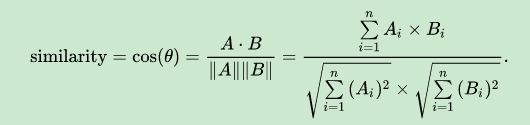

In [34]:
from sklearn.metrics.pairwise import cosine_similarity

In [35]:
a=[[1,3,2],[2,2,1]]
cosine_similarity(a)

array([[1.        , 0.89087081],
       [0.89087081, 1.        ]])

In [36]:
10/(np.sqrt(14)*np.sqrt(9))

0.8908708063747479

In [37]:
def evaluate(filename,embedding_weights):
    if filename.endswith('.csv'):
        data=pd.read_csv(filename,sep=',')
    else:
        data=pd.read_csv(filename,sep='\t')
    human_similarity=[]
    model_similarity=[]
    for i in data.iloc[:,0:2].index:
        word1,word2=data.iloc[i,0],data.iloc[i,1]
        if word1 not in word_to_idx or word2 not in word_to_idx:
            continue
        else:
            word1_idx,word2_idx=word_to_idx[word1],word_to_idx[word2]
            word1_embed,word2_embed=embedding_weights[[word1_idx]],embedding_weights[[word2_idx]]
            model_similarity.append(float(sklearn.metrics.pairwise.cosine_similarity(word1_embed,word2_embed)))
            human_similarity.append(float(data.iloc[i,2]))
    return scipy.stats.spearmanr(human_similarity,model_similarity)

def find_nearest(word):
    index=word_to_idx[word]
    embedding=embedding_weights[index]
    cos_dis=np.array([scipy.spatial.distance.cosine(e,embedding) for e in embedding_weights])
    return [idx_to_word[i] for i in cos_dis.argsort()[:10]]

In [38]:
a=[[1,2,3,7,8,4,5,6],[11,12,14,13,16,15,17,18]]
np.argsort(a)

array([[0, 1, 2, 5, 6, 7, 3, 4],
       [0, 1, 3, 2, 5, 4, 6, 7]], dtype=int64)

In [39]:
b=np.array([1,2,3,7,8,4,5,6])
b.argsort()

array([0, 1, 2, 5, 6, 7, 3, 4], dtype=int64)

In [42]:
optimizer=torch.optim.SGD(model.parameters(),lr=LEARNING_RATE)
for e in range(NUM_EPOCHS):
    for i ,(input_labels,pos_labels,neg_labels) in enumerate(dataloader):
        input_labels=input_labels.long()
        pos_labels=pos_labels.long()
        neg_labels=neg_labels.long()
        
        optimizer.zero_grad()
        loss=model(input_labels,pos_labels,neg_labels).mean()
        loss.backward()
        optimizer.step()
        
        if i %100 ==0:
            with open(LOG_FILE,'a') as fout:
                fout.write('epoch : {},iter: {},loss : {}\n'.format(e,i,loss.item()))
                print("epoch: {}, iter: {}, loss: {}".format(e, i, loss.item()))
        
        if i %200 ==0:
            embedding_weights=model.input_embeddings()
            sim_simlex=evaluate(r'F:\study\ml\DoctorChu-pytorch\2\simlex-999.txt',embedding_weights)
            sim_men=evaluate(r'F:\study\ml\DoctorChu-pytorch\2\men.txt',embedding_weights)
            sim_353=evaluate(r'F:\study\ml\DoctorChu-pytorch\2\wordsim353.csv',embedding_weights)
            with open(LOG_FILE,'a') as fout:
                print('epoch: {},iteration:{},simlex-999:{}'.format(
                e,i,sim_simlex,sim_men,sim_353,find_nearest('monster')))
                fout.write('epoch: {},iteration:{},simlex-999:{}'.format(
                e,i,sim_simlex,sim_men,sim_353,find_nearest('monster')))
    embedding_weights=model.input_embeddings()
    np.save(r"F:\study\ml\DoctorChu-pytorch\2\embedding-{}".format(EMBEDDING_SIZE), embedding_weights)
    torch.save(model.state_dict(), "F:\study\ml\DoctorChu-pytorch\2\embedding-{}.th".format(EMBEDDING_SIZE))

epoch: 0, iter: 0, loss: 420.0466003417969
epoch: 0,iteration:0,simlex-999:SpearmanrResult(correlation=0.037785298219400534, pvalue=0.24363197681905652)
epoch: 0, iter: 100, loss: 275.77777099609375
epoch: 0, iter: 200, loss: 211.04000854492188
epoch: 0,iteration:200,simlex-999:SpearmanrResult(correlation=-0.020995366720437607, pvalue=0.5171772031659221)
epoch: 0, iter: 300, loss: 182.06246948242188
epoch: 0, iter: 400, loss: 149.29022216796875
epoch: 0,iteration:400,simlex-999:SpearmanrResult(correlation=-0.05028662224477816, pvalue=0.12062798597655186)
epoch: 0, iter: 500, loss: 131.10723876953125
epoch: 0, iter: 600, loss: 124.62519836425781
epoch: 0,iteration:600,simlex-999:SpearmanrResult(correlation=-0.03395075379453868, pvalue=0.29484119755111216)
epoch: 0, iter: 700, loss: 112.76646423339844
epoch: 0, iter: 800, loss: 106.7927474975586
epoch: 0,iteration:800,simlex-999:SpearmanrResult(correlation=-0.023627066639495424, pvalue=0.4660557384163787)
epoch: 0, iter: 900, loss: 114.7

epoch: 0,iteration:8000,simlex-999:SpearmanrResult(correlation=0.07609201383690536, pvalue=0.01874453617046994)
epoch: 0, iter: 8100, loss: 34.20955276489258
epoch: 0, iter: 8200, loss: 35.952911376953125
epoch: 0,iteration:8200,simlex-999:SpearmanrResult(correlation=0.07731405241118486, pvalue=0.016920273015933015)
epoch: 0, iter: 8300, loss: 37.518760681152344
epoch: 0, iter: 8400, loss: 35.16366195678711
epoch: 0,iteration:8400,simlex-999:SpearmanrResult(correlation=0.07826342060213563, pvalue=0.015612346339891645)
epoch: 0, iter: 8500, loss: 38.31083297729492
epoch: 0, iter: 8600, loss: 38.29475021362305
epoch: 0,iteration:8600,simlex-999:SpearmanrResult(correlation=0.07717782074672153, pvalue=0.01711562540956092)
epoch: 0, iter: 8700, loss: 35.424381256103516
epoch: 0, iter: 8800, loss: 38.952117919921875
epoch: 0,iteration:8800,simlex-999:SpearmanrResult(correlation=0.0789633653286851, pvalue=0.014705760359953123)
epoch: 0, iter: 8900, loss: 42.65810775756836
epoch: 0, iter: 9000

epoch: 0, iter: 15900, loss: 32.5963134765625
epoch: 0, iter: 16000, loss: 32.204288482666016
epoch: 0,iteration:16000,simlex-999:SpearmanrResult(correlation=0.08253936417255053, pvalue=0.010760101236559795)
epoch: 0, iter: 16100, loss: 32.276309967041016
epoch: 0, iter: 16200, loss: 32.928993225097656
epoch: 0,iteration:16200,simlex-999:SpearmanrResult(correlation=0.08248435597789301, pvalue=0.0108128612875177)
epoch: 0, iter: 16300, loss: 32.67758560180664
epoch: 0, iter: 16400, loss: 32.85658645629883
epoch: 0,iteration:16400,simlex-999:SpearmanrResult(correlation=0.08234011149961577, pvalue=0.010952302582973698)
epoch: 0, iter: 16500, loss: 32.65325164794922
epoch: 0, iter: 16600, loss: 32.298095703125
epoch: 0,iteration:16600,simlex-999:SpearmanrResult(correlation=0.08233479726573492, pvalue=0.010957470193005648)
epoch: 0, iter: 16700, loss: 32.57637023925781
epoch: 0, iter: 16800, loss: 32.916786193847656
epoch: 0,iteration:16800,simlex-999:SpearmanrResult(correlation=0.083372158

epoch: 0,iteration:23800,simlex-999:SpearmanrResult(correlation=0.08516054611144525, pvalue=0.008496437152007829)
epoch: 0, iter: 23900, loss: 31.200136184692383
epoch: 0, iter: 24000, loss: 32.26429748535156
epoch: 0,iteration:24000,simlex-999:SpearmanrResult(correlation=0.08506333502171565, pvalue=0.00857212910321775)
epoch: 0, iter: 24100, loss: 35.788673400878906
epoch: 0, iter: 24200, loss: 32.47003173828125
epoch: 0,iteration:24200,simlex-999:SpearmanrResult(correlation=0.08452292817529185, pvalue=0.009003984955713489)
epoch: 0, iter: 24300, loss: 31.60643196105957
epoch: 0, iter: 24400, loss: 31.976041793823242
epoch: 0,iteration:24400,simlex-999:SpearmanrResult(correlation=0.08531669751426955, pvalue=0.008376100755004254)
epoch: 0, iter: 24500, loss: 31.82170867919922
epoch: 0, iter: 24600, loss: 31.665632247924805
epoch: 0,iteration:24600,simlex-999:SpearmanrResult(correlation=0.08615886191755281, pvalue=0.007752962858116255)
epoch: 0, iter: 24700, loss: 31.636091232299805
epo

KeyboardInterrupt: 

In [17]:
simlex=pd.read_csv(r'F:\study\ml\DoctorChu-pytorch\2\simlex-999.txt',sep='\t')

In [24]:
word_to_idx['aaa']

17156

In [47]:
embedding1.weight.data[[5]]

tensor([[-1.4835, -0.7375,  0.5899]])

In [48]:
embedding1.weight.data[5]

tensor([-1.4835, -0.7375,  0.5899])

In [50]:
sklearn.metrics.pairwise.cosine_similarity(embedding1.weight.data[[5]],
                                           embedding1.weight.data[[6]])

array([[0.80159396]], dtype=float32)

In [23]:
simlex.head()

,word1,word2,simlex999
0,old,new,1.58
1,smart,intelligent,9.20
2,hard,difficult,8.77
3,happy,cheerful,9.55
4,hard,easy,0.95
